<a href="https://colab.research.google.com/github/s-choung/Simulation_tutorials/blob/main/Advanced_dft_optimization_algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Get GPAW as we did last session
- GPAW(+dependencies+ASE)
- POVRAY

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Ign:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy Release [5,713 B]
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy Release.gpg [793 B]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:12 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:13 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,387 kB]
Get:14 http://security.ubuntu.com/ubuntu jam

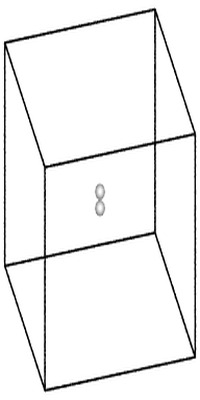

In [1]:
!apt-get update
!apt-get install -y python3-dev libopenblas-dev liblapack-dev libfftw3-dev libxc-dev
!pip install gpaw
!gpaw test
!wget https://wiki.fysik.dtu.dk/gpaw-files/gpaw-setups-24.1.0.tar.gz
!tar -xzf gpaw-setups-24.1.0.tar.gz

import os
import gzip
import shutil

# Define the path to the setup files
setup_path = '/content/gpaw-setups-24.1.0'

# Uncompress all .gz files in the setup directory
for filename in os.listdir(setup_path):
    if filename.endswith('.gz'):
        filepath = os.path.join(setup_path, filename)
        with gzip.open(filepath, 'rb') as f_in:
            with open(filepath[:-3], 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)

# Set the GPAW_SETUP_PATH environment variable
os.environ['GPAW_SETUP_PATH'] = setup_path
# Verify the environment variable
print("GPAW_SETUP_PATH:", os.environ['GPAW_SETUP_PATH'])

# Import ASE and GPAW and run your calculation
from ase import Atoms
from gpaw import GPAW

# Define the atomic structure
d = 0.74
a = 10.0

h2 = Atoms('H2',
              positions=[(0, 0, 0),
                         (0, 0, d)],
              cell=(a, a, a))
h2.center()
# Initialize GPAW calculator without specifying the 'setups' parameter
calc = GPAW(mode='fd', nbands=2, txt='h2.txt')
h2.calc = calc

# Run the calculation
print("Forces on atoms:", h2.get_forces())
print("Energies on atoms:", h2.get_total_energy())

!sudo apt-get install povray  ## visulization program

import shutil
from ase.io import write  # Import the write function from ASE
from PIL import Image
from IPython.display import display  # Import display for Jupyter Notebooks


def visual(structure, max_size=(200, 200), stretch_y=2.0, rotation='15z,-60x', png_save_path='./'):
    renderer = write('./temp.pov', structure, rotation=rotation)
    renderer.render()
    image_path = './temp.png'
    img = Image.open(image_path)

    # Calculate new size with stretch factor
    new_size = (max_size[0], int(max_size[1] * stretch_y))
    img = img.resize(new_size, Image.LANCZOS)
    display(img)

    # Move files to output directory
    files = ['./temp.ini', './temp.pov', './temp.png']
    destination = './output/'

    # Ensure destination directory exists
    os.makedirs(destination, exist_ok=True)

    for file in files:
        # Remove the file in the destination directory if it exists
        if os.path.isfile(os.path.join(destination, os.path.basename(file))):
            os.remove(os.path.join(destination, os.path.basename(file)))

        if file == './temp.png':
            new_file_name = png_save_path + f'temp.png'
        else:
            new_file_name = os.path.basename(file)
        shutil.move(file, os.path.join(destination, new_file_name))
visual(h2)

In [28]:
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from ase import Atoms
from gpaw import GPAW, PW
from ase.build import fcc100
from ase.constraints import FixAtoms
from ase.optimize import BFGS
from ase.io.trajectory import Trajectory

# Initialize the parameters
N_layer = 4 # number of layers
size = 1 #  supercell size
vac = 5
k=1
surf = fcc100('Pt', (size, size, N_layer), vacuum=vac)
#surf.center(axis=2)

# Calculate the median z-position
median_z = np.median(surf.positions[:, 2])

# Apply the constraint to fix atoms below the median z position
constraint = FixAtoms(mask=[atom.position[2] < (median_z + 0.01) for atom in surf])
surf.set_constraint(constraint)

# Set up the GPAW calculator
calc = GPAW(mode=PW(200),
            kpts=(k, k, 1),
            xc='PBE',
            txt='slab.txt')
# Attach the calculator to the slab
surf.calc = calc
# Start timing
start_time = time.time()

#e = surf.get_potential_energy()
opt = BFGS(surf, trajectory='full_rexlaxtion.traj')
opt.run(fmax=0.05)
# End timing
end_time = time.time()
elapsed_time = end_time - start_time
print(f'Time taken: {elapsed_time:.2f} seconds')

      Step     Time          Energy          fmax
BFGS:    0 10:04:23      -32.218130        0.642052
BFGS:    1 10:04:34      -32.227209        0.577032
BFGS:    2 10:04:55      -32.302642        0.554855
BFGS:    3 10:05:09      -32.311843        0.488709
BFGS:    4 10:05:25      -32.324304        0.408202
BFGS:    5 10:05:43      -32.337091        0.272795
BFGS:    6 10:05:56      -32.340680        0.153732
BFGS:    7 10:06:10      -32.342626        0.003689
Time taken: 122.27 seconds


<<<initial structure in DFT loop>>>


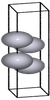

<<<2th structure in DFT loop>>>


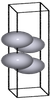

<<<3th structure in DFT loop>>>


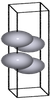

<<<4th structure in DFT loop>>>


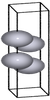

<<<5th structure in DFT loop>>>


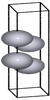

<<<6th structure in DFT loop>>>


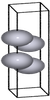

<<<7th structure in DFT loop>>>


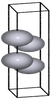

<<<final structure in DFT loop>>>


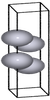

In [32]:
def visual_traj(traj):
  for i,frame in enumerate(traj):
    if i == 0:
      n='initial'
    elif i == len(traj)-1:
      n='final'
    else:
      n=str(i+1)+'th'
    print(f'<<<{n} structure in DFT loop>>>')
    visual(frame,(50,50))

trajectory=Trajectory('./full_rexlaxtion.traj')
visual_traj(trajectory)

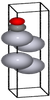

      Step     Time          Energy          fmax
BFGS:    0 09:58:58      -21.191436        2.490904
BFGS:    1 09:59:18      -21.169518        4.657153
BFGS:    2 09:59:37      -21.346511        1.658375
BFGS:    3 09:59:59      -21.427091        1.858746
BFGS:    4 10:00:11      -21.448785        0.774482
BFGS:    5 10:00:24      -21.461350        0.717373
BFGS:    6 10:00:39      -21.486599        1.566629
BFGS:    7 10:00:50      -21.498150        1.071319
BFGS:    8 10:01:03      -21.520791        0.500469
BFGS:    9 10:01:22      -21.534439        0.802818
BFGS:   10 10:01:40      -21.550325        0.999612
BFGS:   11 10:02:01      -21.571503        0.772745
BFGS:   12 10:02:24      -21.587364        0.279080
BFGS:   13 10:02:46      -21.594526        0.956590
BFGS:   14 10:03:04      -21.602350        0.168315
BFGS:   15 10:03:23      -21.605663        0.205211
BFGS:   16 10:03:39      -21.605860        0.104088
BFGS:   17 10:03:52      -21.606402        0.058243
BFGS:   18 10:

In [27]:
import time
import numpy as np
from ase.build import fcc100
from ase.constraints import FixAtoms
from gpaw import GPAW, PW
from ase.build import add_adsorbate

CO = Atoms('CO',
              positions=[(0, 0, 0),
                         (0, 0, 1.1)],
              cell=(a, a, a),pbc='TRUE')
CO.calc = calc
adslab=surf.copy()
add_adsorbate(adslab, CO, 2, 'ontop') #     Supported  adsorption sites: 'ontop', 'bridge', 'fcc' and 'hcp'. (https://gitlab.com/ase/ase/-/blob/master/ase/build/surface.py)
visual(adslab,(50,50))
adslab.calc = calc
# SP calculation

start_time = time.time()
single_point_e = adslab.get_potential_energy()
end_time = time.time()
SP_elapsed_time = end_time - start_time

# Full relax calculation
start_time = time.time()
opt = BFGS(adslab, trajectory='full_rexlaxtion_adslab.traj')
opt.run(fmax=0.05)
end_time = time.time()
full_relax_elapsed_time = end_time - start_time
print('single point time:',SP_elapsed_time)
print('full_relax time:',full_relax_elapsed_time)


<<<initial structure in DFT loop>>>


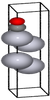

<<<2th structure in DFT loop>>>


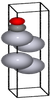

<<<3th structure in DFT loop>>>


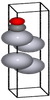

<<<4th structure in DFT loop>>>


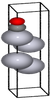

<<<5th structure in DFT loop>>>


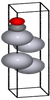

<<<6th structure in DFT loop>>>


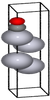

<<<7th structure in DFT loop>>>


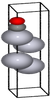

<<<8th structure in DFT loop>>>


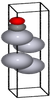

<<<9th structure in DFT loop>>>


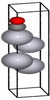

<<<10th structure in DFT loop>>>


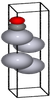

<<<11th structure in DFT loop>>>


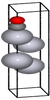

<<<12th structure in DFT loop>>>


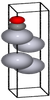

<<<13th structure in DFT loop>>>


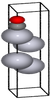

<<<14th structure in DFT loop>>>


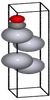

<<<15th structure in DFT loop>>>


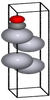

<<<16th structure in DFT loop>>>


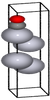

<<<17th structure in DFT loop>>>


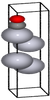

<<<18th structure in DFT loop>>>


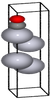

<<<final structure in DFT loop>>>


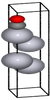

In [33]:
full_rexlaxtion_adslab=Trajectory('./full_rexlaxtion_adslab.traj')
visual_traj(full_rexlaxtion_adslab)